

```
# Código Exemplo: Autoencoders
# Adaptado de https://blog.keras.io/building-autoencoders-in-keras.html
# mlflow server --backend-store-uri=sqlite:///mlflow.db
```



Autoencoder: Versão mais simples possível!

## Imports

In [1]:
import keras

from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

import keras.utils
import mlflow

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import ipykernel

import IPython

keras.utils.Progbar(
    None,
    width=20,
    verbose=1,
    interval=0.5,
    stateful_metrics=None,
    unit_name='step'
)


---
### Dataset

In [2]:
df = pd.read_csv('models\milk_0_val\milk_updated.csv', index_col=['AnEar', 'Date'])

In [3]:
def serialization(dataframe: pd.DataFrame):
    series = []
    for vaca in dataframe.index.levels[0]:
        series.append(dataframe.loc[vaca])
    return np.array(series).squeeze()

In [4]:
series = serialization(df)

In [5]:
import sklearn
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(series,
                                                       train_size=0.8,
                                                       random_state=10,
                                                       shuffle=True,
                                                       )
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

In [6]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [7]:
x_train = x_train.astype('float32') / 255.
#x_train = x_train.astype('float32')
x_test = x_test.astype('float32') / 255.
#x_test = x_test.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


---
### Criação do Modelo

#### Undercomplete Autoencoder

In [8]:
import keras.layers

def undercomplete_create(parameters: dict, size: int):
    dim = list(parameters['dim'])
    for i in range(parameters['intermediate']):
        if (dim[i] > dim[i-1]) & (i>0):
            dim[i] = dim[i-1]
        if dim[i] < parameters['encoder_out']:
            dim[i]=parameters['encoder_out']


    model = Sequential()
    model.add(keras.Input(shape=(size,)))

    for i in range(parameters['intermediate']):
        model.add(layers.Dense(units=dim[i],
                               activation=parameters['activation']
                               ))
        if parameters['dropout'] in [1, 2]:
            model.add(keras.layers.Dropout(parameters['dropout_rate'], seed=10))
    
    
    ################# ENCODER OUTPUT #################
    model.add(layers.Dense(units=parameters['encoder_out'],
                           activation=parameters['activation']
                           ))
    ##################################################

    for i in range(parameters['intermediate']):
        model.add(layers.Dense(units=dim[parameters['intermediate']-i-1],
                               activation=parameters['activation']
                               ))
        if parameters['dropout'] in [2]:
            model.add(keras.layers.Dropout(parameters['dropout_rate'], seed=10))

    model.add(layers.Dense(units=size, activation=parameters['out_activation']))
    
    return model

---
#### Sparse Autoencoder

In [9]:
import keras.layers
import keras.regularizers


def sparse_create(parameters: dict, size: int):
    dim = list(parameters['dim'])
    for i in range(parameters['intermediate']):
        if (dim[i] > dim[i-1]) & (i>0):
            dim[i] = dim[i-1]
        if dim[i] < parameters['encoder_out']:
            dim[i]=parameters['encoder_out']
    
    model = Sequential()
    model.add(keras.Input(shape=(size,)))

    for i in range(parameters['intermediate']):
        model.add(layers.Dense(units=dim[i],
                               activation=parameters['activation'],
                               #activity_regularizer=keras.regularizers.L1(0.01),
                               ))
        
    ################# ENCODER OUTPUT #################
    model.add(layers.Dense(units=parameters['encoder_out'],
                           activation=parameters['activation'],
                           activity_regularizer=keras.regularizers.L1(0.0001),
                           ))
    ##################################################

    for i in range(parameters['intermediate']):
        model.add(layers.Dense(units=dim[parameters['intermediate']-1-i],
                               activation=parameters['activation'],
                               #activity_regularizer=keras.regularizers.L1(0.01),
                               ))

    model.add(layers.Dense(units=size, activation=parameters['out_activation']))
    
    return model

In [10]:
def autoencoder_create(parameters: dict, size: int):
    if parameters['type'] == 'undercomplete':
        model = undercomplete_create(parameters, size)
    elif parameters['type'] == 'sparse':
        model = sparse_create(parameters, size)

    return model

In [11]:
import keras.optimizers

def create_optimizer(parameters):
    if parameters['optimizer']=='adam':
        optimizer = keras.optimizers.Adam(learning_rate=parameters['learning_rate'])
    elif parameters['optimizer']=='sgd':
        optimizer = keras.optimizers.SGD(learning_rate=parameters['learning_rate'])
    elif parameters['optimizer']=='rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=parameters['learning_rate'])  
    else:
        optimizer = keras.optimizers.Adam()      
    return optimizer

---
#### Train Autoencoder

In [12]:
def train_autoencoder(model: keras.Model,
                      train_params: dict,
                      train_dataset,
                      val_dataset,
                      ):
    
    optimizer = create_optimizer(parameters=train_params)

    model.compile(optimizer=optimizer,
                  loss='MeanSquaredError',
                  metrics=['mae'],
                  )

    early = EarlyStopping(monitor='val_loss',
                          mode='min',
                          patience=train_params['early_stop_patience'],
                          restore_best_weights=True,
                          )
    
    callback_list = [early]

    hist = model.fit(x=train_dataset,
                     y=train_dataset,
                     batch_size=train_params['batch_size'],
                     epochs=train_params['epochs'],
                     verbose=1,
                     validation_data=(val_dataset, val_dataset),
                     callbacks=callback_list,
                     )
    
    return model, hist

In [13]:
import mlflow.keras


def run_autoencoder(parameters):
    mlflow.sklearn.autolog(disable=True)
    size = 305

    with mlflow.start_run(run_name='autoencoder'):
        mlflow.set_tag("model_name", "AE")

        mlflow.log_params(parameters['create'])
        mlflow.log_params(parameters['train'])


        model = autoencoder_create(parameters=parameters['create'],
                                   size=size,
                                   )
        
        model, _ = train_autoencoder(model=model,
                                     train_params=parameters['train'],
                                     train_dataset=parameters['train_dataset'],
                                     val_dataset=parameters['val_dataset'],
                                     )

        score, acc = model.evaluate(parameters['val_dataset'],
                                    parameters['val_dataset'],
                                    verbose=0)

        mlflow.log_metrics({'score': score, 'error': acc})

        mlflow.keras.log_model(model, "ae_models")

        print(f'\nTest MSE: {score}\n')
        
    return {'loss': score, 'status': STATUS_OK, 'model': model}

---
### Hyperparameters optimization

In [14]:
hp_space = {
    'create': {'encoder_out': hp.choice('encoder_out', [5,
                                                    50,
                                                    150,
                                                    ]),
                'dim': [ho_scope.int(hp.quniform('1',
                                                 low=0,
                                                 high=305,
                                                 q=1),
                                                 ),
                        ho_scope.int(hp.quniform('2',
                                                 low=0,
                                                 high=305,
                                                 q=1),
                                                 ),
                        ho_scope.int(hp.quniform('3',
                                                 low=0,
                                                 high=305,
                                                 q=1),
                                                 ),
                        ho_scope.int(hp.quniform('4',
                                                 low=0,
                                                 high=305,
                                                 q=1),
                                                 ),
                        ho_scope.int(hp.quniform('5',
                                                 low=0,
                                                 high=305,
                                                 q=1),
                                                 ),],

               'intermediate': ho_scope.int(hp.quniform('intermediate',
                                                        low=0,
                                                        high=3,
                                                        q=1),
                                                        ),
               'activation': hp.choice('activation',
                                        ['relu',
                                         #'softmax',
                                         'sigmoid',
                                         ]),

               'out_activation': hp.choice('out_activation',
                                            [#'relu',
                                             #'softmax',
                                             'sigmoid',
                                             ]),

               'dropout' : hp.choice('dropout', [0,
                                                 #1,
                                                 #2,
                                                 ]),

               'dropout_rate' : hp.quniform('dropout_rate',
                                            low=0.05,
                                            high=0.4,
                                            q=0.05),

               'type' : hp.choice('type',
                                   ['sparse',
                                    'undercomplete',
                                    ]),
               },

    'train': {'epochs': ho_scope.int(hp.quniform('epochs',
                                                 low=50,
                                                 high=300,
                                                 q=10
                                                 )),
                'optimizer': hp.choice('optimizer',
                                       ['adam',
                                        'sgd',
                                        'rmsprop'
                                        ]),

              'learning_rate': hp.quniform('learning_rate',
                                           low=0.0005,
                                           high=0.002,
                                           q=0.0005,
                                           ),
                                           
              'early_stop_patience': ho_scope.int(
                  hp.quniform('early_stop_patience', low=0, high=80, q=10)),
                  
              'batch_size': hp.choice('batch_size', [ 1, 2, 4, 8, 16])
              },

    'train_dataset': train,
    'val_dataset': test,
}

In [15]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("autoencoder_milk")

<Experiment: artifact_location=('file:///c:/Users/Caio/OneDrive/ARQUIVOS/ACADEMICO/4-POS-GRAD '
 'IA/2024-1-MODULO 3/3-DEEP LEARNING/AVALIACAO/mlruns/2'), creation_time=1716390470395, experiment_id='2', last_update_time=1716390470395, lifecycle_stage='active', name='autoencoder_milk', tags={}>

In [16]:
trials = Trials()

In [17]:
best_clf = fmin(fn = run_autoencoder,
                space = hp_space,
                algo = tpe.suggest,
                max_evals = 50,
                trials = trials,
                verbose=True,
                )

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

2024/05/23 00:07:45 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet




Epoch 1/290                                           

5/5 [==============================] - 3s 87ms/step - loss: 0.0489 - mae: 0.1775 - val_loss: 0.0395 - val_mae: 0.1612

Epoch 2/290                                           

5/5 [==============================] - 0s 18ms/step - loss: 0.0454 - mae: 0.1714 - val_loss: 0.0381 - val_mae: 0.1573

  0%|          | 0/50 [00:04<?, ?trial/s, best loss=?]

2024/05/23 00:07:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmphfadn7nx\model\data\model\assets
                                                      
Test MSE: 0.03811407834291458

Epoch 1/140                                                                      

68/68 [==============================] - 1s 5ms/step - loss: 0.0410 - mae: 0.1622 - val_loss: 0.0309 - val_mae: 0.1388

Epoch 2/140                                                                      

68/68 [==============================] - 0s 3ms/step - loss: 0.0354 - mae: 0.1482 - val_loss: 0.0297 - val_mae: 0.1322

Epoch 3/140                                                                      

68/68 [==============================] - 0s 4ms/step - loss: 0.0333 - mae: 0.1419 - val_loss: 0.0275 - val_mae: 0.1307

Epoch 4/140                                                                      

68/68 [==============================] - 0s 4ms/step - loss: 0.0329 - mae: 0.1426 - val_loss: 0.0232 - val_mae: 0.1175

2024/05/23 00:08:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpc7ufcz1j\model\data\model\assets
                                                                                 
Test MSE: 0.010233843699097633

Epoch 1/120                                                                       

17/17 [==============================] - 1s 15ms/step - loss: 0.0473 - mae: 0.1770 - val_loss: 0.0401 - val_mae: 0.1650

Epoch 2/120                                                                       

17/17 [==============================] - 0s 6ms/step - loss: 0.0461 - mae: 0.1742 - val_loss: 0.0380 - val_mae: 0.1596

Epoch 3/120                                                                       

17/17 [==============================] - 0s 6ms/step - loss: 0.0436 - mae: 0.1687 - val_loss: 0.0357 - val_mae: 0.1533

Epoch 4/120                                                                       

17/17 [==============================] - 0s 6ms/step - loss: 0.0421 - mae: 0.1648 - v

2024/05/23 00:09:12 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpfb2lfmt6\model\data\model\assets
                                                                                  
Test MSE: 0.034414470195770264

Epoch 1/290                                                                       

5/5 [==============================] - 1s 51ms/step - loss: 0.0489 - mae: 0.1782 - val_loss: 0.0393 - val_mae: 0.1618

Epoch 2/290                                                                       

5/5 [==============================] - 0s 15ms/step - loss: 0.0464 - mae: 0.1734 - val_loss: 0.0373 - val_mae: 0.1552

Epoch 3/290                                                                       

5/5 [==============================] - 0s 17ms/step - loss: 0.0434 - mae: 0.1669 - val_loss: 0.0351 - val_mae: 0.1480

Epoch 4/290                                                                       

5/5 [==============================] - 0s 13ms/step - loss: 0.0405 - mae: 0.1593 - val_l

2024/05/23 00:09:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpje5ix_7f\model\data\model\assets
                                                                                  
Test MSE: 0.011228230781853199

Epoch 1/70                                                                        

17/17 [==============================] - 1s 14ms/step - loss: 0.0473 - mae: 0.1771 - val_loss: 0.0402 - val_mae: 0.1652

Epoch 2/70                                                                        

17/17 [==============================] - 0s 6ms/step - loss: 0.0465 - mae: 0.1753 - val_loss: 0.0393 - val_mae: 0.1630

Epoch 3/70                                                                        

17/17 [==============================] - 0s 6ms/step - loss: 0.0456 - mae: 0.1736 - val_loss: 0.0384 - val_mae: 0.1606

Epoch 4/70                                                                        

17/17 [==============================] - 0s 6ms/step - loss: 0.0433 - mae: 0.1675 - 

2024/05/23 00:09:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmp8ji6rjqg\model\data\model\assets
                                                                                  
Test MSE: 0.011269275099039078

Epoch 1/270                                                                       

9/9 [==============================] - 1s 22ms/step - loss: 0.0489 - mae: 0.1781 - val_loss: 0.0424 - val_mae: 0.1676

Epoch 2/270                                                                       

9/9 [==============================] - 0s 8ms/step - loss: 0.0489 - mae: 0.1781 - val_loss: 0.0424 - val_mae: 0.1676

Epoch 3/270                                                                       

9/9 [==============================] - 0s 8ms/step - loss: 0.0489 - mae: 0.1781 - val_loss: 0.0424 - val_mae: 0.1676

Epoch 4/270                                                                       

9/9 [==============================] - 0s 9ms/step - loss: 0.0489 - mae: 0.1781 - val_loss

2024/05/23 00:10:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpm7pwtyko\model\data\model\assets
                                                                                  
Test MSE: 0.04201692342758179

Epoch 1/250                                                                       

68/68 [==============================] - 1s 9ms/step - loss: 0.0462 - mae: 0.1729 - val_loss: 0.0353 - val_mae: 0.1525

Epoch 2/250                                                                       

68/68 [==============================] - 0s 7ms/step - loss: 0.0434 - mae: 0.1678 - val_loss: 0.0346 - val_mae: 0.1459

Epoch 3/250                                                                       

68/68 [==============================] - 0s 7ms/step - loss: 0.0434 - mae: 0.1663 - val_loss: 0.0348 - val_mae: 0.1453

Epoch 4/250                                                                       

68/68 [==============================] - 0s 7ms/step - loss: 0.0428 - mae: 0.1643 - va

2024/05/23 00:11:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpe6beq7s5\model\data\model\assets
                                                                                  
Test MSE: 0.013920952565968037

Epoch 1/230                                                                       

68/68 [==============================] - 1s 7ms/step - loss: 0.0420 - mae: 0.1646 - val_loss: 0.0304 - val_mae: 0.1348

Epoch 2/230                                                                       

68/68 [==============================] - 0s 5ms/step - loss: 0.0354 - mae: 0.1480 - val_loss: 0.0285 - val_mae: 0.1326

Epoch 3/230                                                                       

68/68 [==============================] - 0s 5ms/step - loss: 0.0330 - mae: 0.1420 - val_loss: 0.0289 - val_mae: 0.1323

Epoch 4/230                                                                       

68/68 [==============================] - 0s 5ms/step - loss: 0.0324 - mae: 0.1399 - v

2024/05/23 00:12:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpzyu7d0t8\model\data\model\assets
                                                                                  
Test MSE: 0.00956045649945736

Epoch 1/270                                                                       

34/34 [==============================] - 1s 9ms/step - loss: 0.0474 - mae: 0.1772 - val_loss: 0.0403 - val_mae: 0.1653

Epoch 2/270                                                                      

34/34 [==============================] - 0s 4ms/step - loss: 0.0455 - mae: 0.1722 - val_loss: 0.0351 - val_mae: 0.1512

Epoch 3/270                                                                      

34/34 [==============================] - 0s 5ms/step - loss: 0.0386 - mae: 0.1567 - val_loss: 0.0308 - val_mae: 0.1372

Epoch 4/270                                                                      

34/34 [==============================] - 0s 5ms/step - loss: 0.0357 - mae: 0.1486 - val_l

2024/05/23 00:12:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmp63zrvr2f\model\data\model\assets
                                                                                 
Test MSE: 0.014076458290219307

Epoch 1/290                                                                      

9/9 [==============================] - 1s 28ms/step - loss: 0.0443 - mae: 0.1692 - val_loss: 0.0308 - val_mae: 0.1376

Epoch 2/290                                                                      

9/9 [==============================] - 0s 11ms/step - loss: 0.0362 - mae: 0.1493 - val_loss: 0.0295 - val_mae: 0.1318

Epoch 3/290                                                                      

9/9 [==============================] - 0s 10ms/step - loss: 0.0360 - mae: 0.1488 - val_loss: 0.0314 - val_mae: 0.1351

Epoch 4/290                                                                      

9/9 [==============================] - 0s 10ms/step - loss: 0.0340 - mae: 0.1433 - val_loss: 

2024/05/23 00:13:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpykkmh85q\model\data\model\assets
                                                                                 
Test MSE: 0.00998727511614561

Epoch 1/190                                                                       

5/5 [==============================] - 1s 53ms/step - loss: 0.0501 - mae: 0.1797 - val_loss: 0.0360 - val_mae: 0.1510

Epoch 2/190                                                                       

5/5 [==============================] - 0s 15ms/step - loss: 0.0433 - mae: 0.1660 - val_loss: 0.0353 - val_mae: 0.1504

Epoch 3/190                                                                       

5/5 [==============================] - 0s 15ms/step - loss: 0.0427 - mae: 0.1647 - val_loss: 0.0350 - val_mae: 0.1475

Epoch 4/190                                                                       

5/5 [==============================] - 0s 15ms/step - loss: 0.0427 - mae: 0.1634 - val_los

2024/05/23 00:13:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpm_wgjef8\model\data\model\assets
                                                                                  
Test MSE: 0.034356486052274704

Epoch 1/150                                                                       

9/9 [==============================] - 1s 24ms/step - loss: 0.0466 - mae: 0.1751 - val_loss: 0.0376 - val_mae: 0.1574

Epoch 2/150                                                                       

9/9 [==============================] - 0s 9ms/step - loss: 0.0411 - mae: 0.1623 - val_loss: 0.0326 - val_mae: 0.1414

Epoch 3/150                                                                       

9/9 [==============================] - 0s 9ms/step - loss: 0.0369 - mae: 0.1513 - val_loss: 0.0298 - val_mae: 0.1344

Epoch 4/150                                                                       

9/9 [==============================] - 0s 8ms/step - loss: 0.0345 - mae: 0.1467 - val_loss

2024/05/23 00:13:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmphc9bom5o\model\data\model\assets
                                                                                  
Test MSE: 0.010100103914737701

Epoch 1/160                                                                       

9/9 [==============================] - 1s 26ms/step - loss: 0.0500 - mae: 0.1782 - val_loss: 0.0357 - val_mae: 0.1514

Epoch 2/160                                                                       

9/9 [==============================] - 0s 10ms/step - loss: 0.0432 - mae: 0.1654 - val_loss: 0.0353 - val_mae: 0.1490

Epoch 3/160                                                                       

9/9 [==============================] - 0s 9ms/step - loss: 0.0425 - mae: 0.1637 - val_loss: 0.0350 - val_mae: 0.1476

Epoch 4/160                                                                       

9/9 [==============================] - 0s 9ms/step - loss: 0.0421 - mae: 0.1639 - val_los

2024/05/23 00:14:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpvms2y9v0\model\data\model\assets
                                                                                  
Test MSE: 0.0342840850353241

Epoch 1/240                                                                       

5/5 [==============================] - 1s 45ms/step - loss: 0.0487 - mae: 0.1795 - val_loss: 0.0420 - val_mae: 0.1690

Epoch 2/240                                                                       

5/5 [==============================] - 0s 14ms/step - loss: 0.0487 - mae: 0.1795 - val_loss: 0.0420 - val_mae: 0.1690

Epoch 3/240                                                                       

5/5 [==============================] - 0s 13ms/step - loss: 0.0487 - mae: 0.1795 - val_loss: 0.0420 - val_mae: 0.1690

Epoch 4/240                                                                       

5/5 [==============================] - 0s 15ms/step - loss: 0.0487 - mae: 0.1795 - val_los

2024/05/23 00:14:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpcjpm8xfc\model\data\model\assets
                                                                                  
Test MSE: 0.041661594063043594

Epoch 1/160                                                                       

5/5 [==============================] - 0s 37ms/step - loss: 0.0552 - mae: 0.1864 - val_loss: 0.0488 - val_mae: 0.1762

Epoch 2/160                                                                       

5/5 [==============================] - 0s 13ms/step - loss: 0.0552 - mae: 0.1864 - val_loss: 0.0488 - val_mae: 0.1762

Epoch 3/160                                                                       

5/5 [==============================] - 0s 12ms/step - loss: 0.0552 - mae: 0.1864 - val_loss: 0.0488 - val_mae: 0.1762

Epoch 4/160                                                                       

5/5 [==============================] - 0s 10ms/step - loss: 0.0552 - mae: 0.1864 - val_l

2024/05/23 00:14:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpcgo7sags\model\data\model\assets
                                                                                  
Test MSE: 0.04874378442764282

Epoch 1/150                                                                       

68/68 [==============================] - 1s 10ms/step - loss: 0.0400 - mae: 0.1584 - val_loss: 0.0301 - val_mae: 0.1342

Epoch 2/150                                                                       

68/68 [==============================] - 1s 7ms/step - loss: 0.0371 - mae: 0.1490 - val_loss: 0.0328 - val_mae: 0.1379

Epoch 3/150                                                                       

68/68 [==============================] - 1s 8ms/step - loss: 0.0357 - mae: 0.1461 - val_loss: 0.0276 - val_mae: 0.1266

Epoch 4/150                                                                       

68/68 [==============================] - 0s 7ms/step - loss: 0.0323 - mae: 0.1382 - v

2024/05/23 00:16:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpk871m8sa\model\data\model\assets
                                                                                  
Test MSE: 0.01098274439573288

Epoch 1/180                                                                       

34/34 [==============================] - 1s 8ms/step - loss: 0.0405 - mae: 0.1610 - val_loss: 0.0332 - val_mae: 0.1467

Epoch 2/180                                                                       

34/34 [==============================] - 0s 4ms/step - loss: 0.0370 - mae: 0.1521 - val_loss: 0.0325 - val_mae: 0.1445

Epoch 3/180                                                                       

34/34 [==============================] - 0s 4ms/step - loss: 0.0346 - mae: 0.1470 - val_loss: 0.0264 - val_mae: 0.1253

Epoch 4/180                                                                       

34/34 [==============================] - 0s 5ms/step - loss: 0.0334 - mae: 0.1430 - va

2024/05/23 00:16:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpw80rioqb\model\data\model\assets
                                                                                  
Test MSE: 0.009089399129152298

Epoch 1/230                                                                        

34/34 [==============================] - 1s 12ms/step - loss: 0.0426 - mae: 0.1663 - val_loss: 0.0311 - val_mae: 0.1370

Epoch 2/230                                                                        

34/34 [==============================] - 0s 8ms/step - loss: 0.0361 - mae: 0.1497 - val_loss: 0.0299 - val_mae: 0.1348

Epoch 3/230                                                                        

34/34 [==============================] - 0s 8ms/step - loss: 0.0347 - mae: 0.1463 - val_loss: 0.0292 - val_mae: 0.1347

Epoch 4/230                                                                        

34/34 [==============================] - 0s 7ms/step - loss: 0.0329 - mae: 0.140

2024/05/23 00:17:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmp7u06m32f\model\data\model\assets
                                                                                   
Test MSE: 0.008939116261899471

Epoch 1/130                                                                        

17/17 [==============================] - 1s 13ms/step - loss: 0.0473 - mae: 0.1770 - val_loss: 0.0403 - val_mae: 0.1653

Epoch 2/130                                                                        

17/17 [==============================] - 0s 6ms/step - loss: 0.0467 - mae: 0.1757 - val_loss: 0.0398 - val_mae: 0.1641

Epoch 3/130                                                                        

17/17 [==============================] - 0s 5ms/step - loss: 0.0461 - mae: 0.1742 - val_loss: 0.0385 - val_mae: 0.1603

Epoch 4/130                                                                        

17/17 [==============================] - 0s 6ms/step - loss: 0.0442 - mae: 0.16

2024/05/23 00:17:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpfe6xibs3\model\data\model\assets
                                                                                   
Test MSE: 0.014438517391681671

Epoch 1/130                                                                        

68/68 [==============================] - 1s 6ms/step - loss: 0.0476 - mae: 0.1777 - val_loss: 0.0410 - val_mae: 0.1671

Epoch 2/130                                                                        

68/68 [==============================] - 0s 4ms/step - loss: 0.0476 - mae: 0.1777 - val_loss: 0.0410 - val_mae: 0.1671

Epoch 3/130                                                                        

68/68 [==============================] - 0s 5ms/step - loss: 0.0476 - mae: 0.1777 - val_loss: 0.0410 - val_mae: 0.1671

Epoch 4/130                                                                        

68/68 [==============================] - 0s 5ms/step - loss: 0.0476 - mae: 0.177

2024/05/23 00:18:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmp8gm4_2oc\model\data\model\assets
                                                                                   
Test MSE: 0.04092474654316902

Epoch 1/200                                                                        

34/34 [==============================] - 1s 13ms/step - loss: 0.0408 - mae: 0.1624 - val_loss: 0.0305 - val_mae: 0.1345

Epoch 2/200                                                                        

34/34 [==============================] - 0s 9ms/step - loss: 0.0357 - mae: 0.1481 - val_loss: 0.0288 - val_mae: 0.1301

Epoch 3/200                                                                        

34/34 [==============================] - 0s 8ms/step - loss: 0.0345 - mae: 0.1463 - val_loss: 0.0286 - val_mae: 0.1332

Epoch 4/200                                                                        

34/34 [==============================] - 0s 10ms/step - loss: 0.0327 - mae: 0.14

2024/05/23 00:19:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmp1i8flw3z\model\data\model\assets
                                                                                   
Test MSE: 0.009267439134418964

Epoch 1/210                                                                        

34/34 [==============================] - 2s 15ms/step - loss: 0.0457 - mae: 0.1707 - val_loss: 0.0360 - val_mae: 0.1562

Epoch 2/210                                                                        

34/34 [==============================] - 0s 10ms/step - loss: 0.0428 - mae: 0.1649 - val_loss: 0.0391 - val_mae: 0.1642

Epoch 3/210                                                                        

34/34 [==============================] - 0s 9ms/step - loss: 0.0434 - mae: 0.1685 - val_loss: 0.0350 - val_mae: 0.1468

Epoch 4/210                                                                        

34/34 [==============================] - 0s 8ms/step - loss: 0.0426 - mae: 0.1

2024/05/23 00:20:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmp6mk6mq3t\model\data\model\assets
                                                                                   
Test MSE: 0.013926755636930466

Epoch 1/70                                                                         

34/34 [==============================] - 1s 11ms/step - loss: 0.0408 - mae: 0.1610 - val_loss: 0.0315 - val_mae: 0.1368

Epoch 2/70                                                                         

34/34 [==============================] - 0s 6ms/step - loss: 0.0350 - mae: 0.1462 - val_loss: 0.0288 - val_mae: 0.1335

Epoch 3/70                                                                         

34/34 [==============================] - 0s 6ms/step - loss: 0.0344 - mae: 0.1453 - val_loss: 0.0267 - val_mae: 0.1252

Epoch 4/70                                                                         

34/34 [==============================] - 0s 5ms/step - loss: 0.0303 - mae: 0.13

2024/05/23 00:21:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpuvd4201h\model\data\model\assets
                                                                                   
Test MSE: 0.010218121111392975

Epoch 1/100                                                                        

34/34 [==============================] - 1s 11ms/step - loss: 0.0401 - mae: 0.1591 - val_loss: 0.0314 - val_mae: 0.1365

Epoch 2/100                                                                        

34/34 [==============================] - 0s 7ms/step - loss: 0.0359 - mae: 0.1491 - val_loss: 0.0289 - val_mae: 0.1308

Epoch 3/100                                                                        

34/34 [==============================] - 0s 6ms/step - loss: 0.0335 - mae: 0.1436 - val_loss: 0.0276 - val_mae: 0.1287

Epoch 4/100                                                                        

34/34 [==============================] - 0s 6ms/step - loss: 0.0327 - mae: 0.14

2024/05/23 00:21:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpacpib3lp\model\data\model\assets
                                                                                   
Test MSE: 0.009603974409401417

Epoch 1/220                                                                        

34/34 [==============================] - 1s 9ms/step - loss: 0.0472 - mae: 0.1767 - val_loss: 0.0397 - val_mae: 0.1639

Epoch 2/220                                                                        

34/34 [==============================] - 0s 6ms/step - loss: 0.0447 - mae: 0.1714 - val_loss: 0.0359 - val_mae: 0.1531

Epoch 3/220                                                                        

34/34 [==============================] - 0s 5ms/step - loss: 0.0403 - mae: 0.1606 - val_loss: 0.0322 - val_mae: 0.1411

Epoch 4/220                                                                        

34/34 [==============================] - 0s 5ms/step - loss: 0.0370 - mae: 0.152

2024/05/23 00:21:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpl3evb9ye\model\data\model\assets
                                                                                   
Test MSE: 0.01450952049344778

Epoch 1/180                                                                        

34/34 [==============================] - 1s 8ms/step - loss: 0.0591 - mae: 0.1971 - val_loss: 0.0531 - val_mae: 0.1880

Epoch 2/180                                                                        

34/34 [==============================] - 0s 4ms/step - loss: 0.0590 - mae: 0.1970 - val_loss: 0.0530 - val_mae: 0.1879

Epoch 3/180                                                                        

34/34 [==============================] - 0s 4ms/step - loss: 0.0590 - mae: 0.1970 - val_loss: 0.0530 - val_mae: 0.1878

Epoch 4/180                                                                        

34/34 [==============================] - 0s 4ms/step - loss: 0.0589 - mae: 0.1969

2024/05/23 00:22:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmphm6l1dqp\model\data\model\assets
                                                                                   
Test MSE: 0.0469280481338501

Epoch 1/260                                                                        

34/34 [==============================] - 1s 14ms/step - loss: 0.0408 - mae: 0.1644 - val_loss: 0.0302 - val_mae: 0.1376

Epoch 2/260                                                                        

34/34 [==============================] - 0s 8ms/step - loss: 0.0360 - mae: 0.1485 - val_loss: 0.0282 - val_mae: 0.1296

Epoch 3/260                                                                        

34/34 [==============================] - 0s 9ms/step - loss: 0.0370 - mae: 0.1522 - val_loss: 0.0285 - val_mae: 0.1339

Epoch 4/260                                                                        

34/34 [==============================] - 0s 10ms/step - loss: 0.0340 - mae: 0.145

2024/05/23 00:23:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpybceyijr\model\data\model\assets
                                                                                   
Test MSE: 0.009731391444802284

Epoch 1/180                                                                        

34/34 [==============================] - 1s 8ms/step - loss: 0.0470 - mae: 0.1763 - val_loss: 0.0399 - val_mae: 0.1641

Epoch 2/180                                                                        

34/34 [==============================] - 0s 5ms/step - loss: 0.0456 - mae: 0.1730 - val_loss: 0.0386 - val_mae: 0.1601

Epoch 3/180                                                                        

34/34 [==============================] - 0s 5ms/step - loss: 0.0438 - mae: 0.1686 - val_loss: 0.0369 - val_mae: 0.1547

Epoch 4/180                                                                        

34/34 [==============================] - 0s 4ms/step - loss: 0.0420 - mae: 0.164

2024/05/23 00:24:08 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmp3i49oodb\model\data\model\assets
                                                                                   
Test MSE: 0.009843750856816769

Epoch 1/220                                                                        

34/34 [==============================] - 1s 8ms/step - loss: 0.0435 - mae: 0.1682 - val_loss: 0.0322 - val_mae: 0.1408

Epoch 2/220                                                                        

34/34 [==============================] - 0s 5ms/step - loss: 0.0360 - mae: 0.1497 - val_loss: 0.0290 - val_mae: 0.1311

 56%|█████▌    | 28/50 [16:35<15:06, 41.21s/trial, best loss: 0.008939116261899471]

2024/05/23 00:24:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpk4z2jws8\model\data\model\assets
                                                                                   
Test MSE: 0.028980402275919914

Epoch 1/90                                                                         

34/34 [==============================] - 0s 6ms/step - loss: 0.0454 - mae: 0.1711 - val_loss: 0.0336 - val_mae: 0.1459

Epoch 2/90                                                                         

34/34 [==============================] - 0s 4ms/step - loss: 0.0390 - mae: 0.1580 - val_loss: 0.0312 - val_mae: 0.1400

 58%|█████▊    | 29/50 [16:45<11:04, 31.66s/trial, best loss: 0.008939116261899471]

2024/05/23 00:24:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpcm5b7xir\model\data\model\assets
                                                                                   
Test MSE: 0.03118710033595562

Epoch 1/200                                                                        

34/34 [==============================] - 1s 8ms/step - loss: 0.0412 - mae: 0.1607 - val_loss: 0.0320 - val_mae: 0.1428

Epoch 2/200                                                                        

34/34 [==============================] - 0s 5ms/step - loss: 0.0371 - mae: 0.1531 - val_loss: 0.0290 - val_mae: 0.1328

Epoch 3/200                                                                        

34/34 [==============================] - 0s 5ms/step - loss: 0.0330 - mae: 0.1426 - val_loss: 0.0298 - val_mae: 0.1333

Epoch 4/200                                                                        

34/34 [==============================] - 0s 5ms/step - loss: 0.0325 - mae: 0.1410

2024/05/23 00:25:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmphz4ogvdv\model\data\model\assets
                                                                                   
Test MSE: 0.009232261218130589

Epoch 1/170                                                                        

17/17 [==============================] - 0s 13ms/step - loss: 0.0485 - mae: 0.1792 - val_loss: 0.0419 - val_mae: 0.1690

Epoch 2/170                                                                        

17/17 [==============================] - 0s 5ms/step - loss: 0.0485 - mae: 0.1792 - val_loss: 0.0419 - val_mae: 0.1689

Epoch 3/170                                                                        

17/17 [==============================] - 0s 5ms/step - loss: 0.0485 - mae: 0.1792 - val_loss: 0.0419 - val_mae: 0.1689

Epoch 4/170                                                                        

17/17 [==============================] - 0s 5ms/step - loss: 0.0485 - mae: 0.17

2024/05/23 00:25:29 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpcj8ogsi9\model\data\model\assets
                                                                                   
Test MSE: 0.0415259413421154

Epoch 1/240                                                                        

34/34 [==============================] - 1s 10ms/step - loss: 0.0422 - mae: 0.1634 - val_loss: 0.0302 - val_mae: 0.1370

Epoch 2/240                                                                        

34/34 [==============================] - 0s 5ms/step - loss: 0.0363 - mae: 0.1511 - val_loss: 0.0284 - val_mae: 0.1317

Epoch 3/240                                                                        

34/34 [==============================] - 0s 5ms/step - loss: 0.0348 - mae: 0.1473 - val_loss: 0.0245 - val_mae: 0.1226

Epoch 4/240                                                                        

34/34 [==============================] - 0s 6ms/step - loss: 0.0319 - mae: 0.1366

2024/05/23 00:25:58 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpbsag4yqk\model\data\model\assets
                                                                                   
Test MSE: 0.0093199098482728

Epoch 1/110                                                                        

17/17 [==============================] - 0s 11ms/step - loss: 0.0452 - mae: 0.1721 - val_loss: 0.0342 - val_mae: 0.1462

Epoch 2/110                                                                        

17/17 [==============================] - 0s 5ms/step - loss: 0.0370 - mae: 0.1522 - val_loss: 0.0289 - val_mae: 0.1318

Epoch 3/110                                                                        

17/17 [==============================] - 0s 4ms/step - loss: 0.0341 - mae: 0.1445 - val_loss: 0.0274 - val_mae: 0.1286

Epoch 4/110                                                                        

17/17 [==============================] - 0s 5ms/step - loss: 0.0341 - mae: 0.1458

2024/05/23 00:26:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpptbypa3b\model\data\model\assets
                                                                                   
Test MSE: 0.00971264485269785

Epoch 1/290                                                                        

5/5 [==============================] - 1s 41ms/step - loss: 0.0470 - mae: 0.1761 - val_loss: 0.0381 - val_mae: 0.1585

Epoch 2/290                                                                        

5/5 [==============================] - 0s 13ms/step - loss: 0.0433 - mae: 0.1675 - val_loss: 0.0357 - val_mae: 0.1524

Epoch 3/290                                                                        

5/5 [==============================] - 0s 13ms/step - loss: 0.0408 - mae: 0.1615 - val_loss: 0.0335 - val_mae: 0.1444

Epoch 4/290                                                                        

5/5 [==============================] - 0s 14ms/step - loss: 0.0385 - mae: 0.1551 - v

2024/05/23 00:26:45 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmp6hxebako\model\data\model\assets
                                                                                   
Test MSE: 0.010002164170145988

Epoch 1/270                                                                        

34/34 [==============================] - 1s 9ms/step - loss: 0.0416 - mae: 0.1640 - val_loss: 0.0301 - val_mae: 0.1361

Epoch 2/270                                                                        

34/34 [==============================] - 0s 5ms/step - loss: 0.0341 - mae: 0.1438 - val_loss: 0.0346 - val_mae: 0.1459

Epoch 3/270                                                                        

34/34 [==============================] - 0s 5ms/step - loss: 0.0361 - mae: 0.1500 - val_loss: 0.0276 - val_mae: 0.1300

Epoch 4/270                                                                        

34/34 [==============================] - 0s 4ms/step - loss: 0.0313 - mae: 0.138

2024/05/23 00:27:20 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpokbauxo8\model\data\model\assets
                                                                                   
Test MSE: 0.009327307343482971

Epoch 1/200                                                                        

9/9 [==============================] - 1s 33ms/step - loss: 0.0503 - mae: 0.1785 - val_loss: 0.0380 - val_mae: 0.1604

Epoch 2/200                                                                        

9/9 [==============================] - 0s 13ms/step - loss: 0.0451 - mae: 0.1706 - val_loss: 0.0364 - val_mae: 0.1563

Epoch 3/200                                                                        

9/9 [==============================] - 0s 13ms/step - loss: 0.0442 - mae: 0.1682 - val_loss: 0.0366 - val_mae: 0.1581

Epoch 4/200                                                                        

9/9 [==============================] - 0s 13ms/step - loss: 0.0440 - mae: 0.1689 - 

2024/05/23 00:27:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpwjh_1k5o\model\data\model\assets
                                                                                   
Test MSE: 0.034337367862463

Epoch 1/250                                                                        

68/68 [==============================] - 1s 5ms/step - loss: 0.0413 - mae: 0.1619 - val_loss: 0.0295 - val_mae: 0.1329

Epoch 2/250                                                                        

68/68 [==============================] - 0s 4ms/step - loss: 0.0352 - mae: 0.1486 - val_loss: 0.0287 - val_mae: 0.1332

Epoch 3/250                                                                        

68/68 [==============================] - 0s 4ms/step - loss: 0.0331 - mae: 0.1436 - val_loss: 0.0302 - val_mae: 0.1363

Epoch 4/250                                                                        

68/68 [==============================] - 0s 4ms/step - loss: 0.0305 - mae: 0.1361 -

2024/05/23 00:28:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmppe867vy9\model\data\model\assets
                                                                                   
Test MSE: 0.009050264023244381

Epoch 1/250                                                                        

68/68 [==============================] - 1s 5ms/step - loss: 0.0476 - mae: 0.1776 - val_loss: 0.0409 - val_mae: 0.1669

Epoch 2/250                                                                        

68/68 [==============================] - 0s 4ms/step - loss: 0.0476 - mae: 0.1776 - val_loss: 0.0409 - val_mae: 0.1669

 76%|███████▌  | 38/50 [20:30<05:08, 25.70s/trial, best loss: 0.008939116261899471]

2024/05/23 00:28:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmplxm94t8c\model\data\model\assets
                                                                                   
Test MSE: 0.04090258106589317

Epoch 1/300                                                                        

68/68 [==============================] - 1s 5ms/step - loss: 0.0455 - mae: 0.1696 - val_loss: 0.0358 - val_mae: 0.1507

Epoch 2/300                                                                        

68/68 [==============================] - 0s 4ms/step - loss: 0.0399 - mae: 0.1562 - val_loss: 0.0319 - val_mae: 0.1365

Epoch 3/300                                                                        

68/68 [==============================] - 0s 4ms/step - loss: 0.0373 - mae: 0.1489 - val_loss: 0.0306 - val_mae: 0.1322

Epoch 4/300                                                                        

68/68 [==============================] - 0s 4ms/step - loss: 0.0360 - mae: 0.1465

2024/05/23 00:28:39 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpn4n9e9za\model\data\model\assets
                                                                                   
Test MSE: 0.011419039219617844

Epoch 1/280                                                                        

68/68 [==============================] - 1s 5ms/step - loss: 0.0447 - mae: 0.1694 - val_loss: 0.0346 - val_mae: 0.1498

Epoch 2/280                                                                        

68/68 [==============================] - 0s 4ms/step - loss: 0.0428 - mae: 0.1653 - val_loss: 0.0344 - val_mae: 0.1474

Epoch 3/280                                                                        

68/68 [==============================] - 0s 3ms/step - loss: 0.0429 - mae: 0.1643 - val_loss: 0.0344 - val_mae: 0.1469

Epoch 4/280                                                                        

68/68 [==============================] - 0s 4ms/step - loss: 0.0424 - mae: 0.163

2024/05/23 00:29:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpegowg_ni\model\data\model\assets
                                                                                   
Test MSE: 0.01003317628055811

Epoch 1/230                                                                        

68/68 [==============================] - 1s 8ms/step - loss: 0.0402 - mae: 0.1620 - val_loss: 0.0299 - val_mae: 0.1332

Epoch 2/230                                                                        

68/68 [==============================] - 0s 7ms/step - loss: 0.0370 - mae: 0.1528 - val_loss: 0.0282 - val_mae: 0.1296

Epoch 3/230                                                                        

68/68 [==============================] - 0s 6ms/step - loss: 0.0349 - mae: 0.1462 - val_loss: 0.0299 - val_mae: 0.1395

Epoch 4/230                                                                        

68/68 [==============================] - 0s 6ms/step - loss: 0.0333 - mae: 0.1432

2024/05/23 00:31:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmp2y2hpql3\model\data\model\assets
                                                                                   
Test MSE: 0.00946512445807457

Epoch 1/260                                                                        

68/68 [==============================] - 1s 7ms/step - loss: 0.0427 - mae: 0.1659 - val_loss: 0.0312 - val_mae: 0.1369

Epoch 2/260                                                                        

68/68 [==============================] - 0s 5ms/step - loss: 0.0371 - mae: 0.1507 - val_loss: 0.0298 - val_mae: 0.1315

Epoch 3/260                                                                        

68/68 [==============================] - 0s 5ms/step - loss: 0.0350 - mae: 0.1458 - val_loss: 0.0287 - val_mae: 0.1323

Epoch 4/260                                                                        

68/68 [==============================] - 0s 5ms/step - loss: 0.0352 - mae: 0.1481

2024/05/23 00:31:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpyd6l3isd\model\data\model\assets
                                                                                   
Test MSE: 0.009879079647362232

Epoch 1/280                                                                        

17/17 [==============================] - 0s 12ms/step - loss: 0.0491 - mae: 0.1797 - val_loss: 0.0425 - val_mae: 0.1694

Epoch 2/280                                                                        

17/17 [==============================] - 0s 5ms/step - loss: 0.0491 - mae: 0.1797 - val_loss: 0.0424 - val_mae: 0.1694

Epoch 3/280                                                                        

17/17 [==============================] - 0s 5ms/step - loss: 0.0491 - mae: 0.1797 - val_loss: 0.0424 - val_mae: 0.1694

Epoch 4/280                                                                        

17/17 [==============================] - 0s 5ms/step - loss: 0.0491 - mae: 0.17

2024/05/23 00:32:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpej6uwqt2\model\data\model\assets
                                                                                   
Test MSE: 0.04145483300089836

Epoch 1/300                                                                        

9/9 [==============================] - 1s 26ms/step - loss: 0.0514 - mae: 0.1825 - val_loss: 0.0390 - val_mae: 0.1594

Epoch 2/300                                                                        

9/9 [==============================] - 0s 10ms/step - loss: 0.0446 - mae: 0.1691 - val_loss: 0.0354 - val_mae: 0.1502

 88%|████████▊ | 44/50 [24:53<04:18, 43.04s/trial, best loss: 0.008939116261899471]

2024/05/23 00:32:39 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpc2ykb28z\model\data\model\assets
                                                                                   
Test MSE: 0.03541162610054016

Epoch 1/240                                                                        

68/68 [==============================] - 1s 7ms/step - loss: 0.0435 - mae: 0.1665 - val_loss: 0.0334 - val_mae: 0.1391

Epoch 2/240                                                                        

68/68 [==============================] - 0s 5ms/step - loss: 0.0375 - mae: 0.1507 - val_loss: 0.0303 - val_mae: 0.1322

Epoch 3/240                                                                        

68/68 [==============================] - 0s 5ms/step - loss: 0.0357 - mae: 0.1456 - val_loss: 0.0314 - val_mae: 0.1403

Epoch 4/240                                                                        

68/68 [==============================] - 0s 5ms/step - loss: 0.0347 - mae: 0.1451

2024/05/23 00:33:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpueof19ul\model\data\model\assets
                                                                                   
Test MSE: 0.00924108736217022

Epoch 1/220                                                                        

5/5 [==============================] - 1s 44ms/step - loss: 0.0476 - mae: 0.1776 - val_loss: 0.0397 - val_mae: 0.1635

Epoch 2/220                                                                        

5/5 [==============================] - 0s 13ms/step - loss: 0.0442 - mae: 0.1704 - val_loss: 0.0360 - val_mae: 0.1512

Epoch 3/220                                                                        

5/5 [==============================] - 0s 13ms/step - loss: 0.0411 - mae: 0.1620 - val_loss: 0.0341 - val_mae: 0.1449

Epoch 4/220                                                                        

5/5 [==============================] - 0s 13ms/step - loss: 0.0379 - mae: 0.1542 - v

2024/05/23 00:33:55 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpc33b6daj\model\data\model\assets
                                                                                   
Test MSE: 0.009715371765196323

Epoch 1/50                                                                         

68/68 [==============================] - 1s 5ms/step - loss: 0.0445 - mae: 0.1648 - val_loss: 0.0346 - val_mae: 0.1478

Epoch 2/50                                                                         

68/68 [==============================] - 0s 4ms/step - loss: 0.0385 - mae: 0.1524 - val_loss: 0.0290 - val_mae: 0.1303

Epoch 3/50                                                                         

68/68 [==============================] - 0s 4ms/step - loss: 0.0334 - mae: 0.1401 - val_loss: 0.0261 - val_mae: 0.1243

Epoch 4/50                                                                         

68/68 [==============================] - 0s 4ms/step - loss: 0.0288 - mae: 0.128

2024/05/23 00:34:17 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpcd6yh8y6\model\data\model\assets
                                                                                   
Test MSE: 0.01290467381477356

Epoch 1/230                                                                        

9/9 [==============================] - 1s 28ms/step - loss: 0.0478 - mae: 0.1781 - val_loss: 0.0412 - val_mae: 0.1673

Epoch 2/230                                                                        

9/9 [==============================] - 0s 10ms/step - loss: 0.0478 - mae: 0.1781 - val_loss: 0.0412 - val_mae: 0.1673

Epoch 3/230                                                                        

9/9 [==============================] - 0s 9ms/step - loss: 0.0478 - mae: 0.1781 - val_loss: 0.0412 - val_mae: 0.1673

Epoch 4/230                                                                        

9/9 [==============================] - 0s 9ms/step - loss: 0.0478 - mae: 0.1781 - val

2024/05/23 00:34:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpe2ufh_or\model\data\model\assets
                                                                                   
Test MSE: 0.041121941059827805

Epoch 1/250                                                                        

17/17 [==============================] - 1s 14ms/step - loss: 0.0450 - mae: 0.1709 - val_loss: 0.0342 - val_mae: 0.1462

Epoch 2/250                                                                        

17/17 [==============================] - 0s 6ms/step - loss: 0.0368 - mae: 0.1510 - val_loss: 0.0291 - val_mae: 0.1322

Epoch 3/250                                                                        

17/17 [==============================] - 0s 6ms/step - loss: 0.0341 - mae: 0.1452 - val_loss: 0.0271 - val_mae: 0.1271

Epoch 4/250                                                                        

17/17 [==============================] - 0s 6ms/step - loss: 0.0316 - mae: 0.13

2024/05/23 00:35:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



INFO:tensorflow:Assets written to: C:\Users\Caio\AppData\Local\Temp\tmpkft3wdxm\model\data\model\assets
                                                                                   
Test MSE: 0.009296071715652943

100%|██████████| 50/50 [27:40<00:00, 33.22s/trial, best loss: 0.008939116261899471]


In [29]:
best_clf

{'epochs': 30.0, 'intermediate': 1.0, 'out_activation': 1}

In [14]:
logged_model = 'runs:/f1d27c10689e4fbf970ec56cfc1a3ce2/ae_models'
autoencoder = mlflow.pyfunc.load_model(logged_model)

In [224]:
# Encode and decode some digits
# Note that we take them from the *test* set
#encoded_imgs = autoencoder.predict(x_test)
encoded_imgs = model.predict(x_test)

#decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 1ms/step


In [225]:
model.evaluate(x_test,x_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0072 - mae: 0.0260


[0.007154164835810661, 0.026019183918833733]

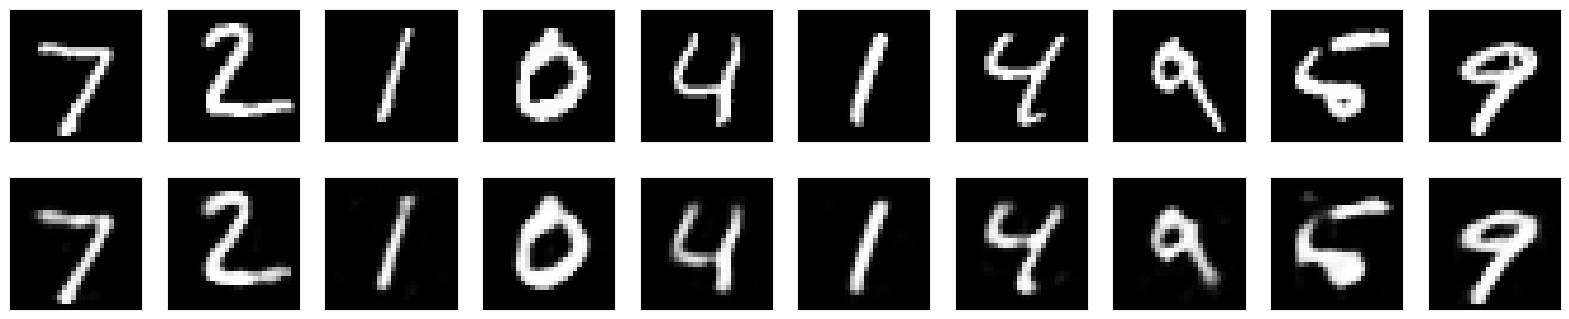

In [226]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(hist.history)

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0.237090,0.239667,0.157878,0.176987
1,0.138415,0.157416,0.124623,0.143248
2,0.118340,0.135067,0.111195,0.126830
3,0.108474,0.122656,0.103780,0.116610
4,0.102842,0.115030,0.099292,0.110182
5,0.099078,0.109650,0.096255,0.105684
6,0.096335,0.105588,0.093773,0.101962
7,0.094197,0.102358,0.092369,0.099574
8,0.092365,0.099477,0.090630,0.097188
9,0.090824,0.097004,0.088932,0.094196


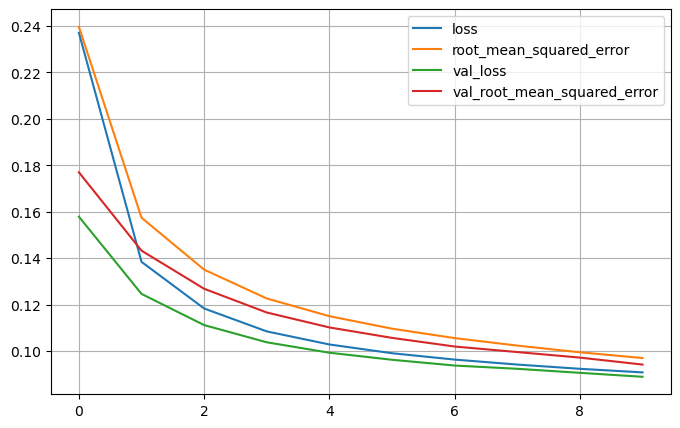

In [20]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(0,0.2)
plt.show()

In [ ]:
history = autoencoder.fit(x=x_train,
                          y=x_train,
                          epochs=10,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

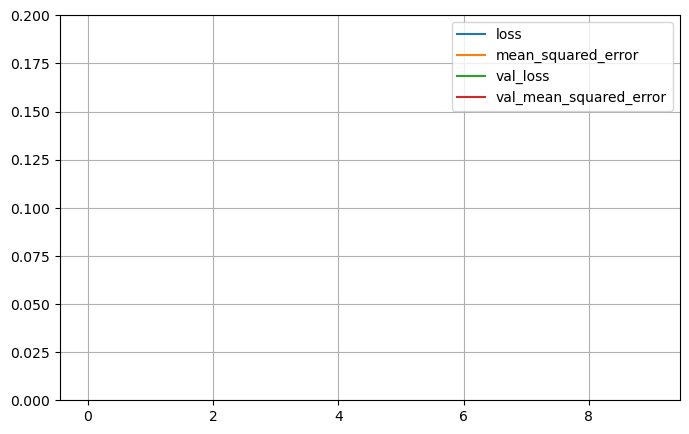

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.2)
plt.show()